<a href="https://colab.research.google.com/github/panzershracker/Time-series-retraining/blob/master/HW_les_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашняя работа к Уроку 2**

Обозначения:

    p - глубина истории, сколько измерений назад учитываем в моделях

    h - горизонт прогноза , на сколько измерений вперед смотрим при 
    моделировании (как далеко предсказываем)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#### **1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .**

In [278]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/DS for business Retraining/les 2/my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [280]:
df.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


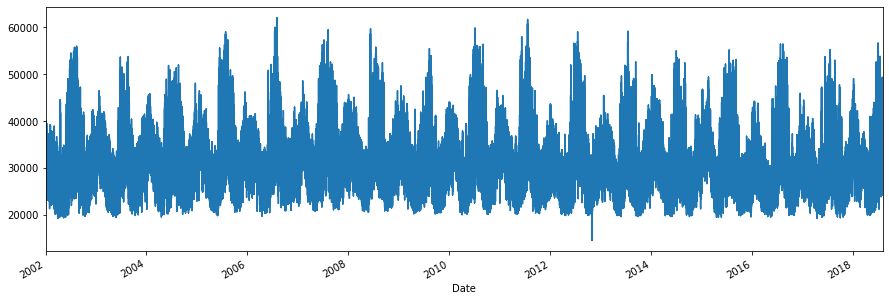

In [281]:
df[df.columns[1]].plot(figsize=(15,5))

In [0]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
def data_split( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
d_data=df.resample('D').mean()

In [0]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

Text(0.5, 1.0, 'PJME_MW')

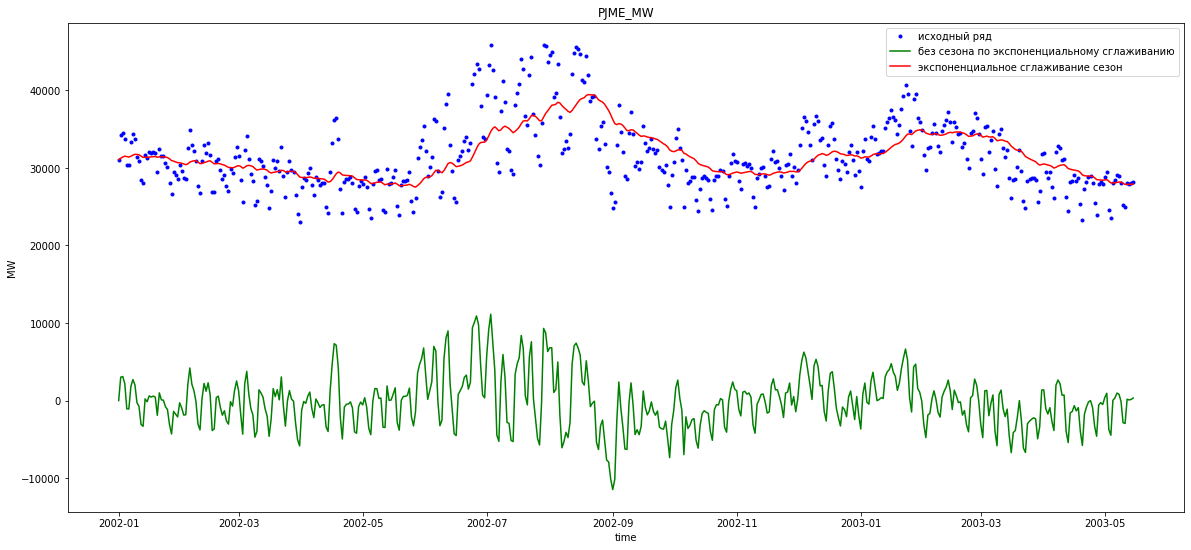

In [287]:
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [288]:
df2= pd.DataFrame(data_exp_1, index=d_data.index)

 # добавили историю на глубину 3 измерения от текущего (р=3)
df2['t'] = 0
df2.iloc[1:,1]=df2.iloc[:-1,0].values
df2['t1']=0
df2.iloc[2:,2]=df2.iloc[:-2,0].values
df2['t2']=0
df2.iloc[3:,3]=df2.iloc[:-3,0].values
df2.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df2['exp_0_01'] = exponential_smoothing(df2[0], 0.01)
df2['exp_0_03'] = exponential_smoothing(df2[0], 0.03)
df2['exp_0_08'] = exponential_smoothing(df2[0], 0.08)
# добавим разности - 1-й порядок
df2['diff1'] = 0
df2['diff1'].iloc[1:] = df2.iloc[:-1,0]-df2.iloc[1:,0]

df2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


In [0]:
from sklearn.ensemble import GradientBoostingRegressor as GB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [0]:
train, test = data_split(df2, '2016-01-01')

In [0]:
h = 1

X_train = train.iloc[:-h,:]
y_train = train[train.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[test.columns[0]].values[h:]

In [292]:
gb_model = GB(max_depth=15, random_state=21, n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
gb_err_h1 = mean_absolute_percentage_error(y_test, y_pred)
print(f'GBoost err = {gb_err_h1}')

GBoost err = 0.5770486787825048


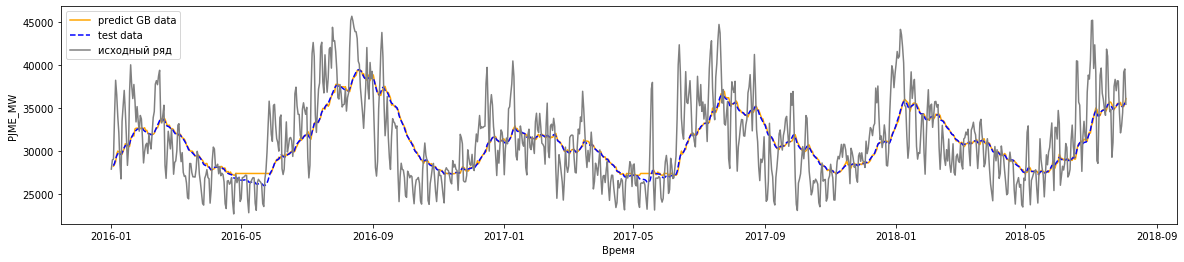

In [293]:
plt.figure( figsize=( 20, 4 ))

plt.plot(test.index[h:], y_pred, label='predict GB data', c='orange')
plt.plot(test.index[h:],y_test, label='test data', c='blue', linestyle='--')
plt.plot(d_data.loc['2016-01-01':].index, d_data.loc['2016-01-01':]['PJME_MW'], label='исходный ряд', c='grey')

plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.legend(loc='best')

In [0]:
h = 10

X_train = train.iloc[:-h,:]
y_train = train[train.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[test.columns[0]].values[h:]

In [309]:
gb_model = GB(max_depth=15, random_state=21, n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
gb_err_h10 = mean_absolute_percentage_error(y_test, y_pred)
print(f'GBoost err = {gb_err_h10}')

GBoost err = 3.693850579936744


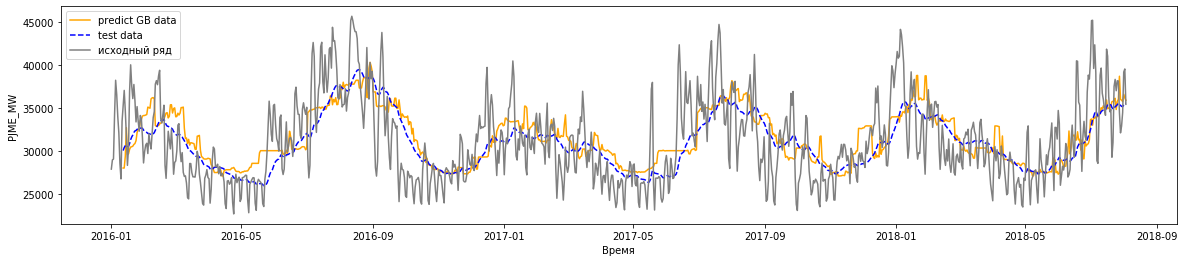

In [296]:
plt.figure( figsize=( 20, 4 ))

plt.plot(test.index[h:], y_pred, label='predict GB data', c='orange')
plt.plot(test.index[h:],y_test, label='test data', c='blue', linestyle='--')
plt.plot(d_data.loc['2016-01-01':].index, d_data.loc['2016-01-01':]['PJME_MW'], label='исходный ряд', c='grey')

plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.legend(loc='best')

#### **Оцените ошибку модели из п.1 .**

In [299]:
print(f'Ошибка градиентного бустинга с глубиной прогноза h=1 == {gb_err_h1}')
print(f'Ошибка градиентного бустинга с глубиной прогноза h=10 == {gb_err_h10}')

Ошибка градиентного бустинга с глубиной прогноза h=1 == 0.5770486787825048
Ошибка градиентного бустинга с глубиной прогноза h=10 == 3.693850579936744


#### **Сделайте вывод о том, как изменилась ошибка модели по значениям h.**

    С увеличение глубины прогноза - ошибка растет и это вполне ожидаемо.

#### **Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):**

а) Изменение температуры за окном :).

    Если наблюдать температуру за окном изнутри - она не будет стационарным 
    рядом, т.к. будут и сезонность, и тренд.
    Если, находясь на улице, наблюдать температуру за окном (т.е. в квартире),
    то она скорее будет похожа на стационарный ряд :)

б) Количество денег, которые тратят покупатели в интернет магазине.

    Этот ряд не стационарный, т.к. скорее всего, присутствует и сезонность и 
    тренд.

в) Вес растущего котенка.

    Этот ряд не стационарен, т.к. в нем будет, до определенного момента,
    постоянно восходящий тренд. Мне кажется, в данном случае ни о какой 
    стационарности не идет речи, т.к. котенок постоянно растет.

г) Прирост объема деревьев в лесу от времени

    Я не понял - здесь имеется ввиду именно обьем каждого дерева, или их общее 
    кол-во.

    Здесь нельзя точно ответить без осмотра данных, т.к. если мы имеем ввиду 
    кол-во деревьев, то вместе с вырубкой, прирост может колебаться в районе
    нуля, и такой ряд будет стационарным. 
    
    Если брять обьем каждого дерева, то этот ряд не будет стационарным, т.к. 
    присутствует тренд.